# Bay Area Bike Share (Aug 2013 - Aug 2015)
### Sachin Dabas | Samarth Gowda | Kevin Chian
### Carnegie Mellon University - Interactive Data Science (05839)
### Helsinki - SanFrancisco Comparision - An Urban Study

This dataset is from the San Francisco Bay Area Bike Share database from August 2013 to August 2015. The bike share is meant to provide people in the Bay Area an easy way to travel around. The dataset is provided as a SQL database and a series of csv files. 

The database and files are available on Kaggle at the following [link](https://www.kaggle.com/benhamner/sf-bay-area-bike-share).

The tables/csv that are available for us to use are `station`, `status`, `trip`, and `weather`. We are interested in combining the trip, station, and weather to create a dataset for each trip. 

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pandas_profiling import ProfileReport
import geopandas as gpd

%matplotlib inline

In [37]:
# INITIALIZING SQLLITE
import sqlite3

DATABASE_PATH = './data/sf/database.sqlite'
conn = sqlite3.connect(DATABASE_PATH)
cursor = conn.cursor()

In [38]:
def run_query(query):
    cursor.execute(query)
    return cursor.fetchall()

def run_pd_query(query):
    return pd.read_sql(query, conn)

### Taking a closer look at our database

In [39]:
# Tables in the database
SELECT_MASTER_QUERY = 'SELECT * FROM sqlite_master'
run_pd_query(SELECT_MASTER_QUERY)

,type,name,tbl_name,rootpage,sql
0,table,station,station,2,CREATE TABLE station (\n id INTEGER PRIMARY...
1,table,status,status,3,"CREATE TABLE status (\n station_id INTEGER,..."
2,table,trip,trip,4,CREATE TABLE trip (\n id INTEGER PRIMARY KE...
3,table,weather,weather,5,"CREATE TABLE weather (\n date TEXT,\n ma..."


In [40]:
# columns in the trip table
run_pd_query("PRAGMA table_info(trip);")

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,duration,INTEGER,0,None,0
2,2,start_date,TEXT,0,None,0
3,3,start_station_name,TEXT,0,None,0
4,4,start_station_id,INTEGER,0,None,0
5,5,end_date,TEXT,0,None,0
6,6,end_station_name,TEXT,0,None,0
7,7,end_station_id,INTEGER,0,None,0
8,8,bike_id,INTEGER,0,None,0
9,9,subscription_type,TEXT,0,None,0


In [41]:
# columns in the station table
run_pd_query("PRAGMA table_info(station);")

,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,name,TEXT,0,None,0
2,2,lat,NUMERIC,0,None,0
3,3,long,NUMERIC,0,None,0
4,4,dock_count,INTEGER,0,None,0
5,5,city,TEXT,0,None,0
6,6,installation_date,TEXT,0,None,0


In [42]:
# columns in the weather table
run_pd_query("PRAGMA table_info(weather);")

,cid,name,type,notnull,dflt_value,pk
0,0,date,TEXT,0,None,0
1,1,max_temperature_f,INTEGER,0,None,0
2,2,mean_temperature_f,INTEGER,0,None,0
3,3,min_temperature_f,INTEGER,0,None,0
4,4,max_dew_point_f,INTEGER,0,None,0
5,5,mean_dew_point_f,INTEGER,0,None,0
6,6,min_dew_point_f,INTEGER,0,None,0
7,7,max_humidity,INTEGER,0,None,0
8,8,mean_humidity,INTEGER,0,None,0
9,9,min_humidity,INTEGER,0,None,0


In [43]:
# columns in the status table
run_pd_query("PRAGMA table_info(status);")

,cid,name,type,notnull,dflt_value,pk
0,0,station_id,INTEGER,0,None,0
1,1,bikes_available,INTEGER,0,None,0
2,2,docks_available,INTEGER,0,None,0
3,3,time,TEXT,0,None,0


In [44]:
MAX_DURATION_QUERY = "SELECT MAX(duration) FROM trip"
run_pd_query(MAX_DURATION_QUERY)

,MAX(duration)
0,17270400


In [45]:
# SQL query to obtain all of the weather information
WEATHER_QUERY = 'SELECT * FROM weather;'
weather_df = run_pd_query(WEATHER_QUERY)

In [46]:
# SQL query to create a row for each trip and the start and end station
TRIP_STATION_QUERY = 'SELECT trip.id AS trip_id, \
                            trip.bike_id AS bike_id, \
                            trip.subscription_type AS subscription_type, \
                            trip.duration AS duration, \
                            trip.start_date AS start_date, \
                            trip.end_date AS end_date, \
                            start_station.name AS start_station_name, \
                            end_station.name AS end_station_name, \
                            start_station.lat AS start_lat, \
                            start_station.long AS start_long, \
                            end_station.lat AS end_lat, \
                            end_station.long AS end_long \
                        FROM trip \
                        JOIN station AS start_station \
                            ON trip.start_station_id = start_station.id \
                        JOIN station AS end_station \
                            ON trip.end_station_id = end_station.id;'

sf_df = run_pd_query(TRIP_STATION_QUERY)

In [47]:
# remove any rows that have empty columns
sf_df = sf_df.dropna(how="any")
weather_df = weather_df.dropna(how="any")

In [48]:
# remove the outliers based on duration
z_scores = stats.zscore(sf_df["duration"])

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
sf_df = sf_df[filtered_entries]

In [49]:

# convert the start and end dates to pandas datetime
sf_df["start_datetime"] = pd.to_datetime(sf_df["start_date"], format='%m/%d/%Y %H:%M', errors="coerce")
sf_df["end_datetime"] = pd.to_datetime(sf_df["end_date"], format='%m/%d/%Y %H:%M', errors="coerce")

sf_df["start_date"] = sf_df["start_datetime"].dt.date
sf_df["end_date"] = sf_df["end_datetime"].dt.date

weather_df["date"] = pd.to_datetime(weather_df["date"], format='%m/%d/%Y')

# add month column
sf_df["start_month"] = sf_df["start_datetime"].dt.month_name()
sf_df["end_month"] = sf_df["end_datetime"].dt.month_name()
weather_df["month"] = weather_df["date"].dt.month_name()

# add year column
sf_df["start_year"] = sf_df["start_datetime"].dt.year
sf_df["end_year"] = sf_df["end_datetime"].dt.year

# add day column
sf_df["start_day"] = sf_df["start_datetime"].dt.day_name()
sf_df["end_day"] = sf_df["end_datetime"].dt.day_name()

# add hour column
sf_df["start_hour"] = sf_df["start_datetime"].dt.hour
sf_df["end_hour"] = sf_df["end_datetime"].dt.hour

# make duration into minutes
sf_df["duration_min"] = sf_df["duration"] / 60


In [50]:
sf_df.head()

,trip_id,bike_id,subscription_type,duration,start_date,end_date,start_station_name,end_station_name,start_lat,start_long,...,end_datetime,start_month,end_month,start_year,end_year,start_day,end_day,start_hour,end_hour,duration_min
0,4069,288,Subscriber,174,2013-08-29,2013-08-29,2nd at South Park,2nd at South Park,37.782259,-122.392738,...,2013-08-29 09:11:00,August,August,2013,2013,Thursday,Thursday,9,9,2.900000
1,4073,321,Subscriber,1067,2013-08-29,2013-08-29,South Van Ness at Market,San Francisco Caltrain 2 (330 Townsend),37.774814,-122.418954,...,2013-08-29 09:42:00,August,August,2013,2013,Thursday,Thursday,9,9,17.783333
2,4074,317,Subscriber,1131,2013-08-29,2013-08-29,South Van Ness at Market,San Francisco Caltrain 2 (330 Townsend),37.774814,-122.418954,...,2013-08-29 09:43:00,August,August,2013,2013,Thursday,Thursday,9,9,18.850000
3,4075,316,Subscriber,1117,2013-08-29,2013-08-29,South Van Ness at Market,San Francisco Caltrain 2 (330 Townsend),37.774814,-122.418954,...,2013-08-29 09:43:00,August,August,2013,2013,Thursday,Thursday,9,9,18.616667
4,4076,322,Subscriber,1118,2013-08-29,2013-08-29,South Van Ness at Market,San Francisco Caltrain 2 (330 Townsend),37.774814,-122.418954,...,2013-08-29 09:43:00,August,August,2013,2013,Thursday,Thursday,9,9,18.633333


In [51]:
weather_df.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code,month
0,2013-08-29,74,68,61,61,58,56,93,75,57,...,10,23,11,28,0,4,,286,94107,August
1,2013-08-30,78,69,60,61,58,56,90,70,50,...,7,29,13,35,0,2,,291,94107,August
2,2013-08-31,71,64,57,57,56,54,93,75,57,...,10,26,15,31,0,4,,284,94107,August
3,2013-09-01,74,66,58,60,56,53,87,68,49,...,10,25,13,29,0,4,,284,94107,September
4,2013-09-02,75,69,62,61,60,58,93,77,61,...,6,23,12,30,0,6,,277,94107,September


In [52]:
sf_df.value_counts("subscription_type")

subscription_type
Subscriber    566651
Customer      102569
dtype: int64

### Let's perform some exploratory data analysis on our datasets

In [53]:
profile = ProfileReport(sf_df, title="Pandas Profiling Report on SF Bike", minimal=True)
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


### Examining trip date/month/hour and durations

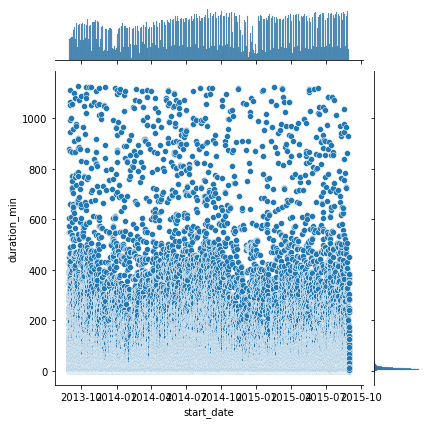

In [54]:
ax = sns.jointplot(data=sf_df, x="start_date", y="duration_min")

[(0.0, 40.0)]

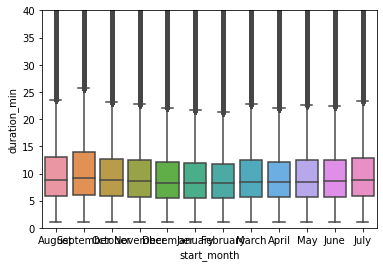

In [55]:
ax = sns.boxplot(data=sf_df, x="start_month", y="duration_min")
ax.set(ylim=(0, 40))

[(0.0, 40.0)]

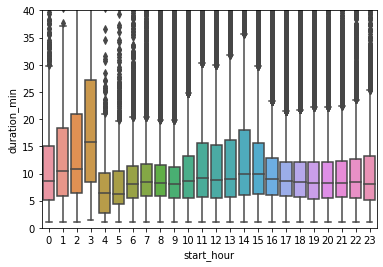

In [56]:
ax = sns.boxplot(data=sf_df, x="start_hour", y="duration_min")
ax.set(ylim=(0, 40))

We are able to see from a few of our exploratory graphs above that for both the `duration_min` vs `start_month` and `duration_min` vs `start_date`, it is hard to see any significant relationship forming. However, when looking at the duration based on the time of day, we can see that there does seem to be some sort of relationship. In particular, 6am-10am and 4pm-8pm have very similar trip durations. This makes sense as people are probably using the city bikes for commuting. We can see that there are slightly longer trips taken during the middle of day, probably for lunch breaks or other errands. Surprisingly, 1am-3am has the longest trip durations, which can probably be accounted for people taking the bikes back from a night out since other forms of transportation are not running.

### Number of rides taken based on date/month/hour

Text(0.5, 1.0, 'Count of the rides vs Month')

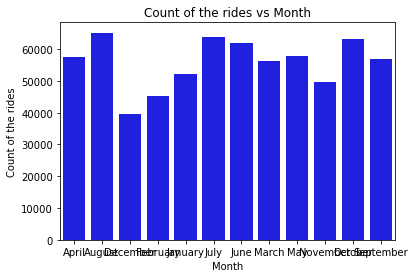

In [57]:
cnt = sf_df.groupby("start_month").size().reset_index()
sns.barplot(data=cnt, x=cnt["start_month"], y=cnt[0], color="b")
plt.ylabel("Count of the rides")
plt.xlabel("Month")
plt.title("Count of the rides vs Month")

Text(0.5, 1.0, 'Count of the rides vs Hour')

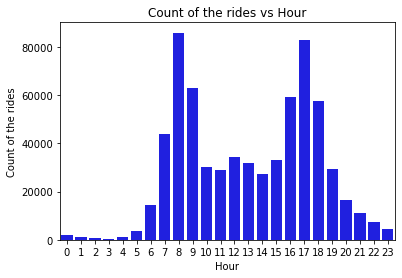

In [58]:
cnt = sf_df.groupby("start_hour").size().reset_index()
sns.barplot(data=cnt, x=cnt["start_hour"], y=cnt[0], color="b")
plt.ylabel("Count of the rides")
plt.xlabel("Hour")
plt.title("Count of the rides vs Hour")

We can take a look at the above graphs and see that the count of rides vs hour bar plot seems to be bimodal with morning rush hour and evening rush hour having spikes in usage of the bikes. We can also see that in the summer months, there seems to be a somewhat linear increase in the number of rides. However, it is interesting to see that in September, the bike are used less and in October, the number of rides increases back to the level it was in July. 

### Plots on the temperature

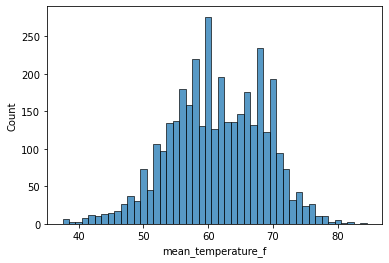

In [59]:
ax = sns.histplot(weather_df["mean_temperature_f"])

### Location information for the rides

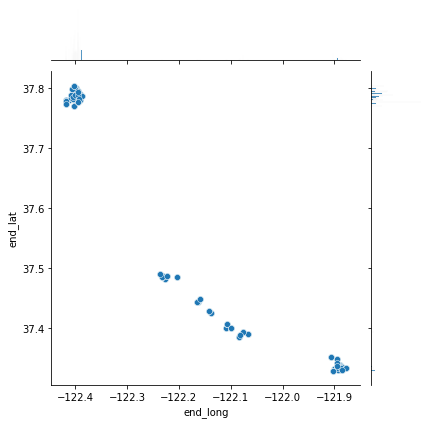

In [60]:
ax = sns.jointplot(data=sf_df, x="end_long", y="end_lat")

In [61]:
# load in the shape file for SF
road_gdf_sf = gpd.read_file("./data/sf/shape/tl_2017_06075_roads.shp")

In [62]:
start_stations = pd.DataFrame({'count' : sf_df.groupby( [ "start_long", "start_lat"] ).size()}).reset_index()
start_gdf = gpd.GeoDataFrame(start_stations,
                                 geometry=gpd.points_from_xy(start_stations["start_long"],
                                                             start_stations["start_lat"]),
                                )
# normalize count to values between 0 and 1
start_gdf["count"] = ((start_gdf["count"] - start_gdf["count"].min()) /
                        (start_gdf["count"].max()- start_gdf["count"].min()))

<AxesSubplot:>

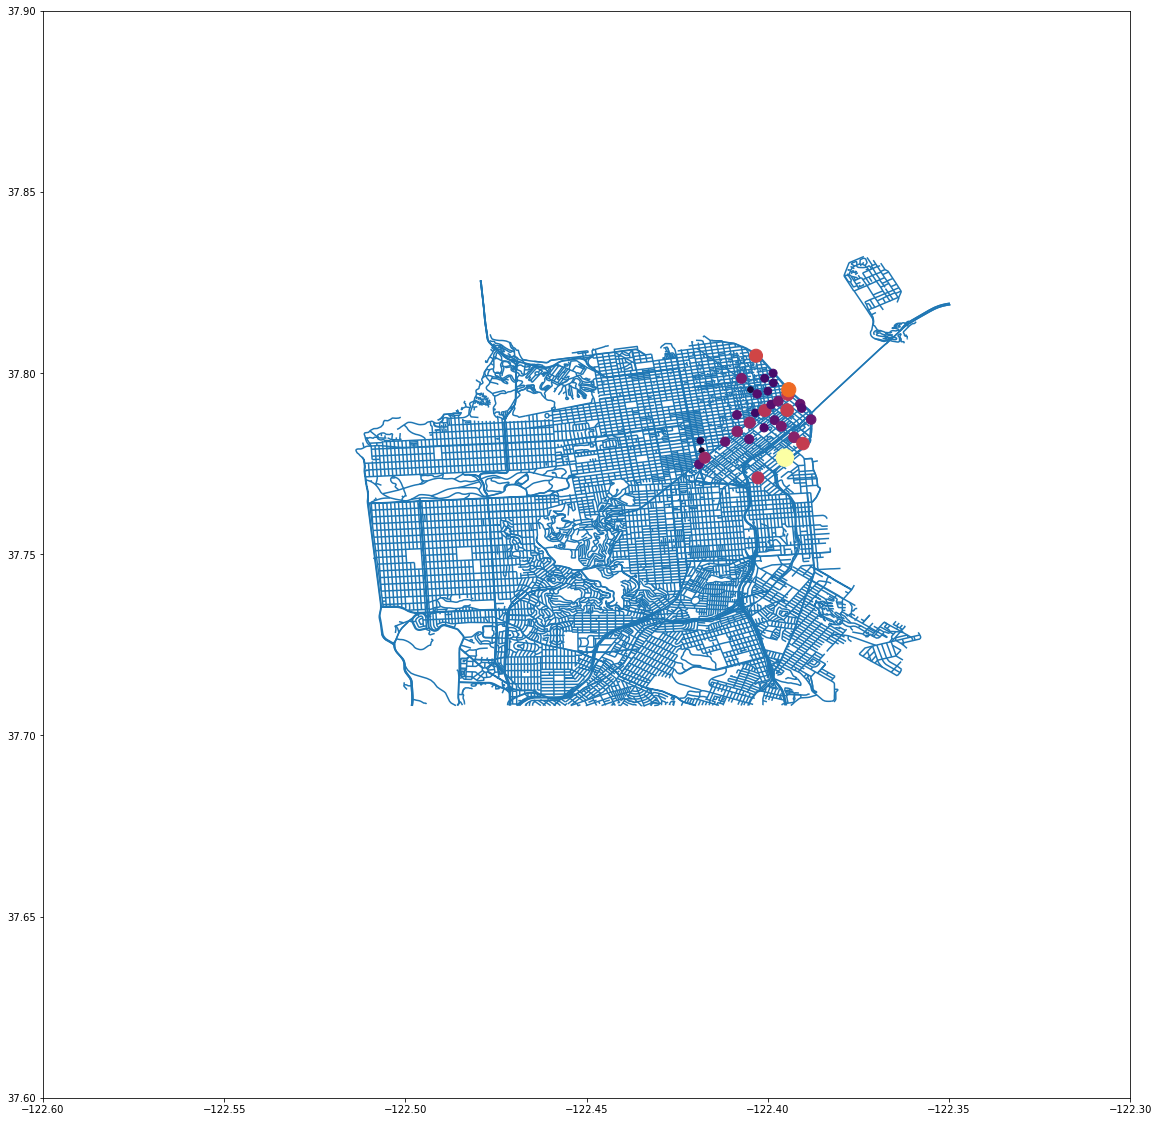

In [63]:
ax = road_gdf_sf.plot(figsize=(20, 20))
ax.set(ylim=(37.6, 37.9), xlim=(-122.6, -122.3))
start_gdf.plot(column="count", ax=ax, cmap="inferno", zorder=3, markersize=start_gdf["count"]*300)

Since the Bay Area extends down below San Francisco, there are trips that are happening there as well. For this exploratory analysis, we used a shape file for San Francisco roads and focused our graph on showing the the number of trips that are happening in SF alone. 

<AxesSubplot:>

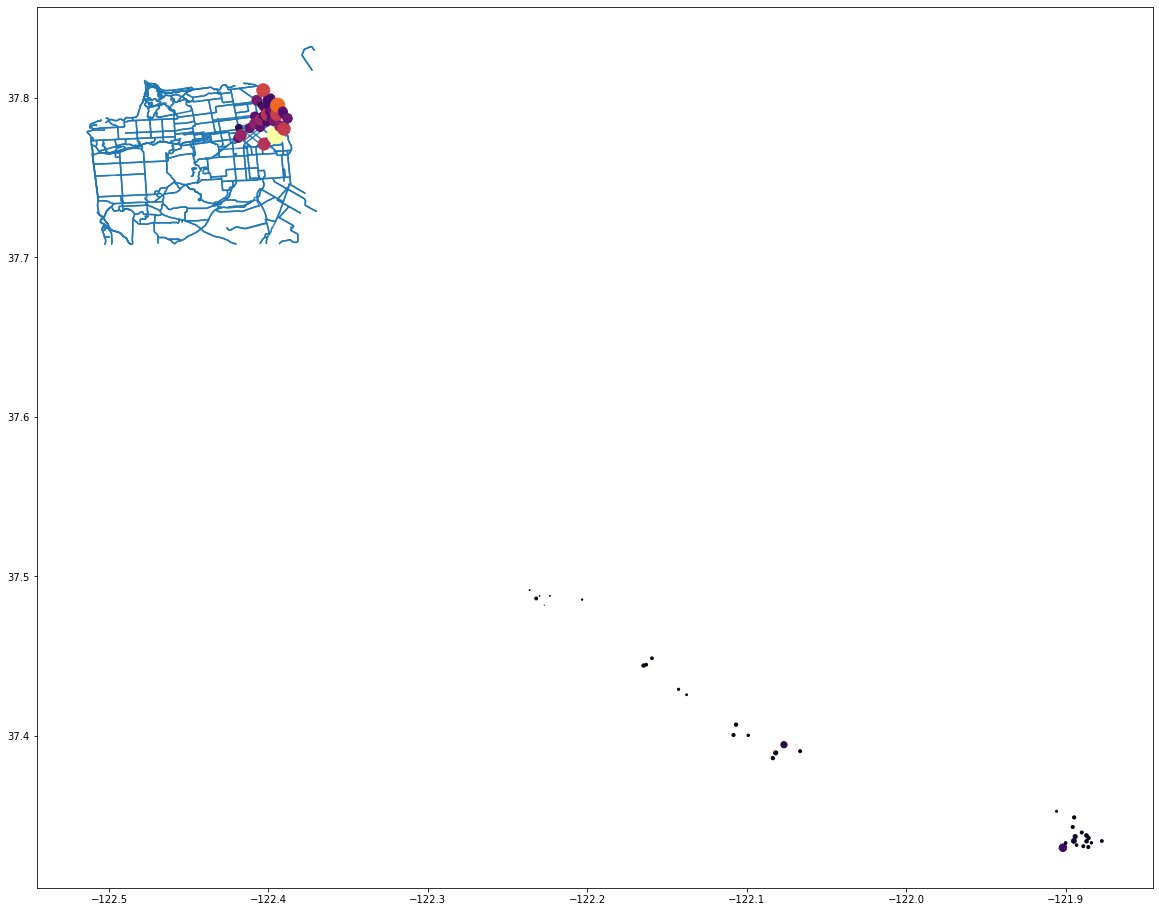

In [64]:
# Bikeway, not just roads.
bikeway_gdf_sf = gpd.read_file("./data/sf/shape/bikeway.shp")
ax = bikeway_gdf_sf.plot(figsize=(20, 20))
# ax.set(ylim=(37.7, 37.85), xlim=(-122.45, -122.35))
start_gdf.plot(column="count", ax=ax, cmap="inferno", zorder=3, markersize=start_gdf["count"]*300)

### Saving transformed dataset as csv

In [66]:
jan_df = sf_df.loc[sf_df["start_month"] == "January"]
feb_df = sf_df.loc[sf_df["start_month"] == "February"]
mar_df = sf_df.loc[sf_df["start_month"] == "March"]
apr_df = sf_df.loc[sf_df["start_month"] == "April"]
may_df = sf_df.loc[sf_df["start_month"] == "May"]
june_df = sf_df.loc[sf_df["start_month"] == "June"]
july_df = sf_df.loc[sf_df["start_month"] == "July"]
aug_df = sf_df.loc[sf_df["start_month"] == "August"]
sep_df = sf_df.loc[sf_df["start_month"] == "September"]
oct_df = sf_df.loc[sf_df["start_month"] == "October"]
nov_df = sf_df.loc[sf_df["start_month"] == "November"]
dec_df = sf_df.loc[sf_df["start_month"] == "December"]

jan_df.to_csv("./data/sf/trips/jan.csv")
feb_df.to_csv("./data/sf/trips/feb.csv")
mar_df.to_csv("./data/sf/trips/mar.csv")
apr_df.to_csv("./data/sf/trips/apr.csv")
may_df.to_csv("./data/sf/trips/may.csv")
june_df.to_csv("./data/sf/trips/june.csv")
july_df.to_csv("./data/sf/trips/july.csv")
aug_df.to_csv("./data/sf/trips/aug.csv")
sep_df.to_csv("./data/sf/trips/sep.csv")
oct_df.to_csv("./data/sf/trips/oct.csv")
nov_df.to_csv("./data/sf/trips/nov.csv")
dec_df.to_csv("./data/sf/trips/dec.csv")

In [67]:
sf_df.to_csv("./data/sf/trips.csv")
weather_df.to_csv("./data/sf/weather.csv")